In [9]:
# delete the beginning and ending of the images
# for rgb image and depth image in zed_front camera only retain 195th-850th images
# for other image in zed_top and zed_side, find the nearest timestep for 195th image and 850th image 
# and only retain the images between these two timesteps
import os
import open3d as o3d

# Define directories and camera intrinsics
directories = {
    "front": {
        "rgb": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/193426/bag_images/rgb",
        "depth": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/193426/bag_images/depth"
    },
    "top": {
        "rgb": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/193426/bag_top_images/rgb",
        "depth": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/193426/bag_top_images/depth"
    },
    "side": {
        "rgb": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/193426/bag_side_images/rgb",
        "depth": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/193426/bag_side_images/depth"
    }
}
def find_nearest_timestamp(target, timestamps):
    nearest = None
    smallest_diff = float('inf')
    for timestamp in timestamps:
        diff = abs(timestamp - target)
        if diff < smallest_diff:
            nearest = timestamp
            smallest_diff = diff
    return nearest

def retain_images_between_timestamps(rgb_dir, depth_dir, start_timestamp, end_timestamp):
    rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])
    depth_files = sorted([f for f in os.listdir(depth_dir) if f.endswith('.png')])

    retained_rgb_files = []
    retained_depth_files = []

    for rgb_file, depth_file in zip(rgb_files, depth_files):
        timestamp = int(rgb_file.split('.')[0])
        if start_timestamp <= timestamp <= end_timestamp:
            retained_rgb_files.append(rgb_file)
            retained_depth_files.append(depth_file)

    for rgb_file in rgb_files:
        if rgb_file not in retained_rgb_files:
            os.remove(os.path.join(rgb_dir, rgb_file))

    for depth_file in depth_files:
        if depth_file not in retained_depth_files:
            os.remove(os.path.join(depth_dir, depth_file))

# Process the front camera
front_rgb_dir = directories["front"]["rgb"]
front_depth_dir = directories["front"]["depth"]

# Retain only the 195th to 850th images for the front camera
front_rgb_files = sorted([f for f in os.listdir(front_rgb_dir) if f.endswith('.png')])
front_depth_files = sorted([f for f in os.listdir(front_depth_dir) if f.endswith('.png')])

# Retain only the specified range for front camera
retained_front_rgb_files = front_rgb_files[194:850]
retained_front_depth_files = front_depth_files[194:850]

# Remove the non-retained images for front camera
for rgb_file in front_rgb_files:
    if rgb_file not in retained_front_rgb_files:
        os.remove(os.path.join(front_rgb_dir, rgb_file))

for depth_file in front_depth_files:
    if depth_file not in retained_front_depth_files:
        os.remove(os.path.join(front_depth_dir, depth_file))

# Get timestamps for the 195th and 850th images in the front camera
start_timestamp = int(retained_front_rgb_files[0].split('.')[0])
end_timestamp = int(retained_front_rgb_files[-1].split('.')[0])

# Process the top and side cameras
for key in ["top", "side"]:
    rgb_dir = directories[key]["rgb"]
    depth_dir = directories[key]["depth"]

    rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])
    timestamps = [int(f.split('.')[0]) for f in rgb_files]

    start_timestamp_for_camera = find_nearest_timestamp(start_timestamp, timestamps)
    end_timestamp_for_camera = find_nearest_timestamp(end_timestamp, timestamps)

    retain_images_between_timestamps(rgb_dir, depth_dir, start_timestamp_for_camera, end_timestamp_for_camera)

print("Image retention and removal completed.")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Image retention and removal completed.


In [45]:
import os
import cv2
import open3d as o3d

# Define directories and camera intrinsics
directories = {
    "front": {
        "rgb": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/bag_images/rgb",
        "depth": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/bag_images/depth",
        "point": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/pointcloud",
        "intrinsics": (1070.1000, 1070.4301, 939.8100, 549.6520)
    }}
    # "top": {
    #     "rgb": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/bag_top_images/rgb",
    #     "depth": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/bag_top_images/depth",
    #     "point": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/pointcloud_top",
    #     "intrinsics": (1060.4000, 1060.0100, 946.0600, 496.6630)
    # },
    # "side": {
    #     "rgb": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/bag_side_images/rgb",
    #     "depth": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/bag_side_images/depth",
    #     "point": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/pointcloud_side",
    #     "intrinsics": (1066.4000, 1065.9900, 970.8000, 547.1950)
    # }


# Function to process images and generate point clouds
def process_images_and_generate_pointclouds(rgb_dir, depth_dir, point_dir, intrinsics):
    if not os.path.exists(point_dir):
        os.makedirs(point_dir)

    rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])
    depth_files = sorted([f for f in os.listdir(depth_dir) if f.endswith('.png')])
    pointcloud_count = 0

    for rgb_file, depth_file in zip(rgb_files, depth_files):
        rgb_image_path = os.path.join(rgb_dir, rgb_file)
        depth_image_path = os.path.join(depth_dir, depth_file)
        
        color_raw = o3d.io.read_image(rgb_image_path)
        depth_raw = o3d.io.read_image(depth_image_path)
        # color_raw = cv2.imread(rgb_image_path)
        # depth_raw = cv2.imread(depth_image_path)
        # color_hd = cv2.resize(color_raw, (1920, 1080), interpolation=cv2.INTER_CUBIC)
        # depth_hd = cv2.resize(depth_raw, (1920, 1080), interpolation=cv2.INTER_CUBIC)

        # depth_hd = o3d.geometry.Image(depth_hd)
        # color_hd = o3d.geometry.Image(color_hd)
        
        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)
        fx, fy, cx, cy = intrinsics
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
            rgbd_image,
            o3d.camera.PinholeCameraIntrinsic(
                width=1920,
                height=1080,
                fx=fx, fy=fy,
                cx=cx, cy=cy
            )
        )
        pcd.transform([[-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
        pointcloud_path = os.path.join(point_dir, rgb_file.replace('.png', '.pcd'))
        o3d.io.write_point_cloud(pointcloud_path, pcd)
        pointcloud_count += 1

    print(f"Total number of point clouds generated for {point_dir}: {pointcloud_count}")

# Process each set of directories
for key, value in directories.items():
    process_images_and_generate_pointclouds(value["rgb"], value["depth"], value["point"], value["intrinsics"])


Total number of point clouds generated for /home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/pointcloud: 328


In [1]:
import os
import open3d as o3d

# Define directories and camera intrinsics
directories = {
    "front": {
        "rgb": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/441364/bag_images/rgb",
        "depth": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/441364/bag_images/depth",
        "point": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/441364/pointcloud",
        "intrinsics": (1070.1000, 1070.4301, 939.8100, 549.6520)
    },
    "top": {
        "rgb": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/441364/bag_top_images/rgb",
        "depth": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/441364/bag_top_images/depth",
        "point": "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/441364/pointcloud_top",
        "intrinsics": (1060.4000, 1060.0100, 946.0600, 496.6630)
    }
}

# Function to process images and generate point clouds
def process_images_and_generate_pointclouds(rgb_dir, depth_dir, point_dir, intrinsics):
    if not os.path.exists(point_dir):
        os.makedirs(point_dir)

    rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])
    depth_files = sorted([f for f in os.listdir(depth_dir) if f.endswith('.png')])
    pointcloud_count = 0

    for rgb_file, depth_file in zip(rgb_files, depth_files):
        rgb_image_path = os.path.join(rgb_dir, rgb_file)
        depth_image_path = os.path.join(depth_dir, depth_file)
        
        color_raw = o3d.io.read_image(rgb_image_path)
        depth_raw = o3d.io.read_image(depth_image_path)
        
        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)
        fx, fy, cx, cy = intrinsics
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
            rgbd_image,
            o3d.camera.PinholeCameraIntrinsic(
                width=1920,
                height=1080,
                fx=fx, fy=fy,
                cx=cx, cy=cy
            )
        )
        pcd.transform([[-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
        pointcloud_path = os.path.join(point_dir, rgb_file.replace('.png', '.pcd'))
        o3d.io.write_point_cloud(pointcloud_path, pcd)
        pointcloud_count += 1

    print(f"Total number of point clouds generated for {point_dir}: {pointcloud_count}")

# Process each set of directories
for key, value in directories.items():
    process_images_and_generate_pointclouds(value["rgb"], value["depth"], value["point"], value["intrinsics"])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Total number of point clouds generated for /home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/441364/pointcloud: 929
Total number of point clouds generated for /home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/441364/pointcloud_top: 928


In [4]:
import os
import open3d as o3d
def load_point_cloud(file_path):
    return o3d.io.read_point_cloud(file_path)
pointcloud_path = '/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/xie_try_2/napkin_red45/pointcloud_top/1717607079437722851.pcd'
front_pcd = load_point_cloud(pointcloud_path)
# color_raw = o3d.io.read_image(rgb_image_path)

vis = o3d.visualization.Visualizer()
vis.create_window(width=1920, height=1080)
vis.add_geometry(front_pcd)
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis.add_geometry(origin)


vis.run()
vis.destroy_window()

In [27]:
a = np.asarray(color_raw)
a.min(), a.max()

(0, 4000)

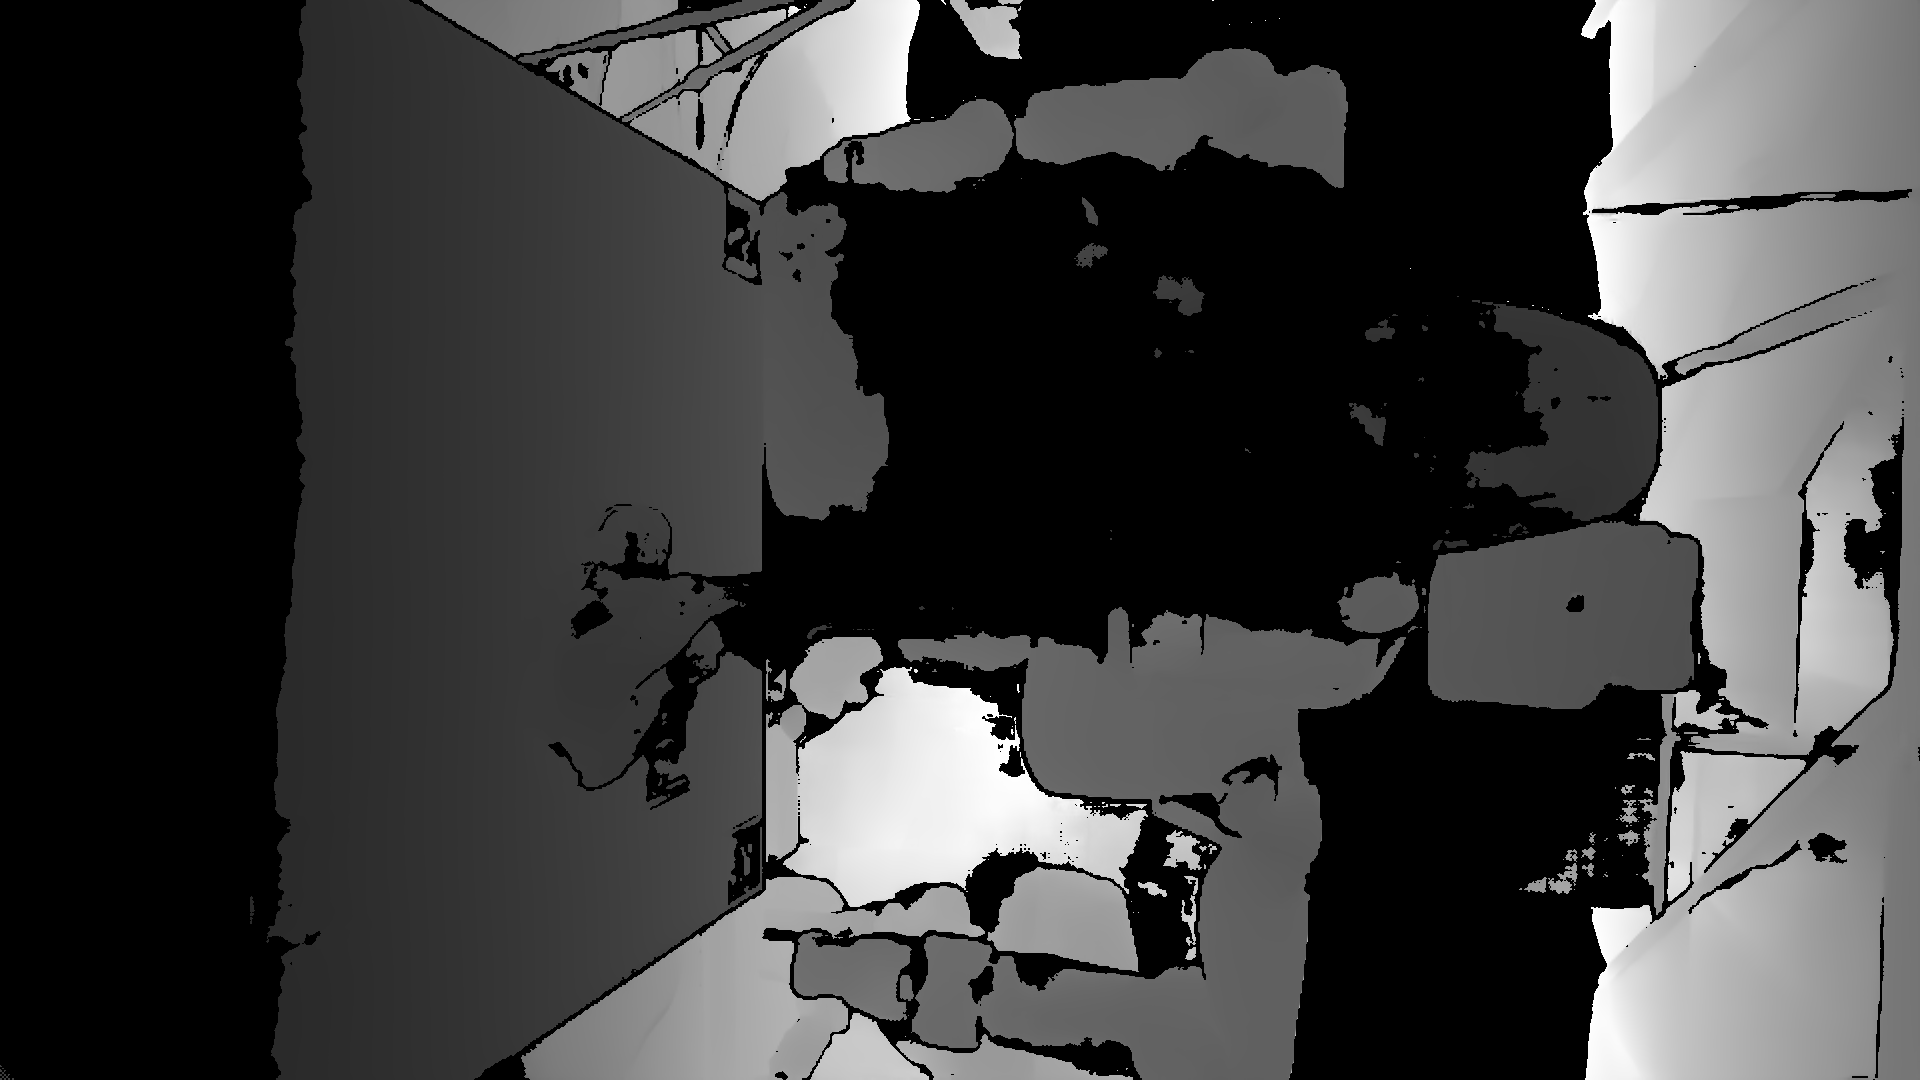

In [28]:
import torch
n_a = (a - a.min()) / (a.max() - a.min())

t_n_a = torch.tensor(n_a)

import torchvision.transforms.functional as TF

TF.to_pil_image(t_n_a)

In [23]:
a.shape

(1080, 1920)

In [24]:
a[960, 540]

885

In [38]:
np.asarray(pcd.points)[:,2].min(), np.asarray(pcd.points)[:,2].max()

(1.9607843160629272, 9.803921699523926)

In [52]:
np.asarray(pcd.points)

array([[ 1.79974885,  1.05537848,  2.07800007],
       [ 1.79694167,  1.05487052,  2.0769999 ],
       [ 1.79500073,  1.05487052,  2.0769999 ],
       ...,
       [-1.42907509, -0.77934808,  1.59099996],
       [-1.42696528, -0.77738872,  1.58700001],
       [-1.42484788, -0.77542929,  1.58299994]])

In [27]:
np.asarray(pcd.points)[:,1].min(), np.asarray(pcd.points)[:,1].max()

(-3.97144368426501, 9.958467423121942)

In [34]:
np.asarray(pcd.points)[:,2].min(), np.asarray(pcd.points)[:,2].max()

(-0.004999999888241291, -0.0010000000474974513)

In [41]:
np.asarray(color_raw).min(), np.asarray(color_raw).max(), np.asarray(color_raw).shape

(0, 255, (1080, 1920, 3))

In [2]:
import open3d as o3d
import numpy as np
depth_image_path= '/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/116491/bag_images/depth/1717084676117768427.png'
depth_raw = o3d.io.read_image(depth_image_path)
np.asarray(depth_raw).min(), np.asarray(depth_raw).max(), np.asarray(depth_raw).shape

(0, 4000, (1080, 1920))

In [47]:
np.asarray(depth_raw)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [7]:
# match gripper
# gripper open and close situation in total_time.json -- extract the ros time for each open and close(for each gripper) 
# -- find the nearest timestep in the action (.csv) and print the number of row
import json
import pandas as pd
import numpy as np

total_time_path = "/media/ubb/Seagate Backup Plus Drive/human_demonstration/lipeng1_checked/napkin_pink30_5/total_time.json"
tracker1_path_zed = "/media/ubb/Seagate Backup Plus Drive/human_demonstration/lipeng1_checked/napkin_pink30_5/bag/tracker_1/pose_converted_times_zed.csv"

tracker4_path_zed = "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/try/pant_pink/bag/tracker_4/pose_converted_times_zed.csv"



In [8]:
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

In [9]:
def load_csv_data(file_path):
    return pd.read_csv(file_path)

In [10]:
# def find_nearest_time(csv_timestamps, target_time):
#     nearest_index = np.abs(csv_timestamps - target_time).argmin()
#     return nearest_index
def find_nearest_timestamp(target, timestamps):
    nearest_index = None
    nearest_value = None
    smallest_diff = float('inf')
    for index, timestamp in enumerate(timestamps):
        diff = abs(timestamp - target)
        if diff < smallest_diff:
            nearest_index = index
            nearest_value = timestamp
            smallest_diff = diff
    return nearest_index, nearest_value

# timestamps = [1.5, 2.3, 4.7, 6.0, 7.8]  # Example list of timestamps
# target_timestamp = 4.0

# nearest_index = find_nearest_timestamp(target_timestamp, timestamps)
# print(nearest_index)

in total_time.json: left_picked/ right_picked /left_placed/ placed/ right_placed / picked
related to tracker_3:right_picked/ right_placed/ placed/ picked
related to tracker_4:left_picked/ placed/  left_placed/ picked
find the nearest timestamp -- can know row number and point cloud number -- single display: change tracker color and point out the corner
                                                                         -- animation: change tracker color and point out the corner

In [11]:
# for zed camera
gripper_data = load_json_data(total_time_path)
tracker1_zed = load_csv_data(tracker1_path_zed)
tracker4_zed = load_csv_data(tracker4_path_zed)


# Assuming the CSV file has a 'timestamp' column with ROS times as float
tracker1_time_zed = tracker1_zed['time'].values
tracker4_time_zed = tracker4_zed['time'].values


import pandas as pd

def process_events_and_pair(tracker_data, gripper_data, pick_keys, place_keys):
    # Extract and prepare pick and place data
    pick_times = []
    for key in pick_keys:
        for _, time_str in gripper_data.get(key, []):
            time_cleaned = int(time_str.strip('"').replace('.', '').ljust(19, '0'))
            pick_times.append(time_cleaned)
    
    place_times = []
    for key in place_keys:
        for _, time_str in gripper_data.get(key, []):
            time_cleaned = int(time_str.strip('"').replace('.', '').ljust(19, '0'))
            place_times.append(time_cleaned)

    # Sort the times
    pick_times.sort()
    place_times.sort()

    # Pairing assuming equal lengths after sorting
    pairs = list(zip(pick_times, place_times))
    return pairs

# Process events for Tracker 3 (right picks and places)
tracker1_pairs = process_events_and_pair(
    tracker1_zed,
    gripper_data,
    ['right_picked', 'picked'],  # Pick keys for tracker 3
    ['right_placed', 'placed']   # Place keys for tracker 3
)

# # Process events for Tracker 4 (left picks and places)
tracker4_pairs = process_events_and_pair(
    tracker4_zed,
    gripper_data,
    ['left_picked', 'picked'],   # Pick keys for tracker 4
    ['left_placed', 'placed']    # Place keys for tracker 4
)

# Output the pairs
print("Tracker 1 Pairs:", tracker1_pairs)
print("Tracker 4 Pairs:", tracker4_pairs)




Tracker 1 Pairs: [(1717596881350162809, 1717596885208302931), (1717596887708045545, 1717596889797080777)]
Tracker 4 Pairs: [(1717596878705214222, 1717596885208302931), (1717596887708045545, 1717596889797080777), (1717596891885316612, 1717596893884062087), (1717596895520158699, 1717596896897227011)]


In [6]:
# edit the .csv
def mark_interval_in_dataframe(tracker_df, pairs):
    tracker_df['gripper']=0
    for start_time, end_time in pairs:
        tracker_df.loc[(tracker_df['time'] >= start_time) & (tracker_df['time'] <= end_time), 'gripper'] = 1
    return tracker_df

tracker1_completezed = mark_interval_in_dataframe(tracker1_zed, tracker1_pairs)
tracker4_completezed = mark_interval_in_dataframe(tracker4_zed, tracker4_pairs)


# Optionally save the modified DataFrame back to CSV
tracker1_completezed.to_csv("/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/try/pant_pink/bag/tracker_1/tracker1_zed_modified.csv", index=False)
tracker4_completezed.to_csv("/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/try/pant_pink/bag/tracker_4/tracker4_zed_modified.csv", index=False)


In [40]:
'''
gripper_data = load_json_data(total_time_path)
tracker3_zed = load_csv_data(tracker3_path_zed)
tracker4_zed = load_csv_data(tracker4_path_zed)

# Assuming the CSV file has a 'timestamp' column with ROS times as float
tracker3_time_zed = tracker3_zed['time'].values
tracker4_time_zed = tracker4_zed['time'].values

tracker_3_gripper_zed = []
tracker_4_gripper_zed =[]
# Process each category in the JSON data
for category, times in gripper_data.items():
    print(f"Category: {category}")
    for time_data in times:
        ros_time_str = time_data[1]
        ros_time_clean = ros_time_str.strip('"')
        ros_time_nodecimal = ros_time_clean.replace('.','')
        if len(ros_time_nodecimal) < 19:
            ros_time_nodecimal = ros_time_nodecimal.ljust(19, '0')
        
        ros_time = int(ros_time_nodecimal)
        if category in ['right_picked', 'right_placed', 'placed', 'picked']:
            nearest_index,nearest_value = find_nearest_timestamp(ros_time, tracker3_time_zed)
            print(f"  ROS Time: {ros_time}, index:{nearest_index}, value: {nearest_value}")
            tracker_3_gripper_zed.append((category, nearest_index))
        if category in ['left_picked', 'left_placed', 'placed', 'picked']:
            nearest_index,nearest_value = find_nearest_timestamp(ros_time, tracker4_time_zed)
            print(f"  ROS Time: {ros_time}, index:{nearest_index}, value: {nearest_value}")
            tracker_4_gripper_zed.append((category, nearest_index)) 

print("Tracker 3 Gripper Actions for zed with Indices:", tracker_3_gripper_zed)
print("Tracker 4 Gripper Actions for zed with Indices:", tracker_4_gripper_zed)
'''

Category: start_time
Category: left_picked
  ROS Time: 1714316447591652147, index:32, value: 1714316447588337770
  ROS Time: 1714316453383750878, index:149, value: 1714316453396495228
  ROS Time: 1714316462463803038, index:340, value: 1714316462471433744
Category: right_picked
  ROS Time: 1714316449956395060, index:81, value: 1714316449964125255
  ROS Time: 1714316460112367632, index:292, value: 1714316460128650239
  ROS Time: 1714316473544107058, index:565, value: 1714316473559407090
Category: left_placed
  ROS Time: 1714316451167746960, index:106, value: 1714316451185425314
  ROS Time: 1714316463712027810, index:365, value: 1714316463725828173
Category: placed
  ROS Time: 1714316458327774223, index:254, value: 1714316458313292607
  ROS Time: 1714316458327774223, index:254, value: 1714316458313476340
  ROS Time: 1714316468256163030, index:457, value: 1714316468246195795
  ROS Time: 1714316468256163030, index:457, value: 1714316468246380371
  ROS Time: 1714316471760951389, index:530, v

In [44]:
'''
gripper_data = load_json_data(total_time_path)
tracker3_zedtop = load_csv_data(tracker3_path_zedtop)
tracker4_zedtop = load_csv_data(tracker4_path_zedtop)

# Assuming the CSV file has a 'timestamp' column with ROS times as float
tracker3_time_zedtop = tracker3_zedtop['time'].values
tracker4_time_zedtop = tracker4_zedtop['time'].values

tracker_3_gripper_zedtop = []
tracker_4_gripper_zedtop =[]
# Process each category in the JSON data
for category, times in gripper_data.items():
    print(f"Category: {category}")
    for time_data in times:
        ros_time_str = time_data[1]
        ros_time_clean = ros_time_str.strip('"')
        ros_time_nodecimal = ros_time_clean.replace('.','')
        if len(ros_time_nodecimal) < 19:
            ros_time_nodecimal = ros_time_nodecimal.ljust(19, '0')
        ros_time = int(ros_time_nodecimal)

        if category in ['right_picked', 'right_placed', 'placed', 'picked']:
            nearest_index,nearest_value = find_nearest_timestamp(ros_time, tracker3_time_zedtop)
            print(f"  ROS Time: {ros_time}, index:{nearest_index}, value: {nearest_value}")
            tracker_3_gripper_zedtop.append((category, nearest_index))
        if category in ['left_picked', 'left_placed', 'placed', 'picked']:
            nearest_index,nearest_value = find_nearest_timestamp(ros_time, tracker4_time_zedtop)
            print(f"  ROS Time: {ros_time}, index:{nearest_index}, value: {nearest_value}")
            tracker_4_gripper_zedtop.append((category, nearest_index)) 
print("Tracker 3 Gripper Actions with Indices:", tracker_3_gripper_zedtop)
print("Tracker 4 Gripper Actions with Indices:", tracker_4_gripper_zedtop)
'''

Category: start_time
Category: left_picked
  ROS Time: 1714316447591652147, index:33, value: 1714316447588337770
  ROS Time: 1714316453383750878, index:154, value: 1714316453396495228
  ROS Time: 1714316462463803038, index:331, value: 1714316462471433744
Category: right_picked
  ROS Time: 1714316449956395060, index:83, value: 1714316449931367899
  ROS Time: 1714316460112367632, index:285, value: 1714316460128650239
  ROS Time: 1714316473544107058, index:558, value: 1714316473526199732
Category: left_placed
  ROS Time: 1714316451167746960, index:109, value: 1714316451152495710
  ROS Time: 1714316463712027810, index:356, value: 1714316463725828173
Category: placed
  ROS Time: 1714316458327774223, index:250, value: 1714316458313292607
  ROS Time: 1714316458327774223, index:250, value: 1714316458313476340
  ROS Time: 1714316468256163030, index:449, value: 1714316468246195795
  ROS Time: 1714316468256163030, index:449, value: 1714316468246380371
  ROS Time: 1714316471760951389, index:520, v

draw a single point cloud
for zed camera: read the 33th point cloud of zed, read the 33th row of action(.csv) and change color
original color--red and green
if left pick -- tracker3 turn to purple / right pick -- tracker4 turn to purple/ pick -- tracker3 and tracker4 turn to purple


Tracker 3 Gripper Actions with Indices: [('left_picked', 33), ('left_picked', 150), ('left_picked', 341), ('left_placed', 107), ('left_placed', 365), ('placed', 255), ('placed', 458), ('placed', 531), ('picked', 406), ('picked', 491)]
Tracker 4 Gripper Actions with Indices: [('right_picked', 1), ('right_picked', 293), ('right_picked', 566), ('placed', 255), ('placed', 458), ('placed', 530), ('right_placed', 313), ('right_placed', 610), ('picked', 406), ('picked', 491)]

visualize the grasping point! 

In [50]:
import ast
import csv
import numpy as np
import cv2
import open3d as o3d
import os


def quaternion_to_rotation_matrix(quat):
    """Convert quaternion [w, x, y, z] to a 4x4 rotation matrix."""
    w, x, y, z = quat
    tx = 2.0 * x
    ty = 2.0 * y
    tz = 2.0 * z
    twx = tx * w
    twy = ty * w
    twz = tz * w
    txx = tx * x
    txy = ty * x
    txz = tz * x
    tyy = ty * y
    tyz = tz * y
    tzz = tz * z
 
    return np.array([[1.0 - (tyy + tzz), txy - twz, txz + twy, 0],
                     [txy + twz, 1.0 - (txx + tzz), tyz - twx, 0],
                     [txz - twy, tyz + twx, 1.0 - (txx + tyy), 0],
                     [0, 0, 0, 1]])
 
def transform_point_cloud(pcd, translation, quaternion):
    """Apply transformation defined by a translation and quaternion rotation to a point cloud."""
    # Create the transformation matrix
    rotation_matrix = quaternion_to_rotation_matrix(quaternion)
    rotation_matrix_inversed = np.linalg.inv(rotation_matrix)
    #print(rotation_matrix)
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix[:3, :3]
    transformation_matrix[:3, 3] = translation

    # transformation_matrix = [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]] @ transformation_matrix
 
    # Transform the point cloud
    transformed_pcd = pcd.transform(transformation_matrix) # left multiplication
    #print(np.asarray(transformed_pcd.points))

    return transformed_pcd
 

def read_tracker_data(file_path):
    """Read the tracker data from a file and return the position and quaternion."""
    positions = []
    quaternions = []
    grippers = []
    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for i, row in enumerate(reader):
            # if i % 20 == 0:  
            pos = ast.literal_eval(row['position'])
            ori = ast.literal_eval(row['orientation'])
            gripper = int(row['gripper'])
            positions.append(np.array([pos['x'], pos['y'], pos['z']]))
            quaternions.append([
                round(ori['w'],3),
                round(ori['x'],3), 
                round(ori['y'],3),
                round(ori['z'],3)])
            grippers.append(gripper)
    return positions, quaternions, grippers

def set_camera_view(vis):
    control = vis.get_view_control()
    camera_parameters = o3d.camera.PinholeCameraParameters()
    camera_parameters.intrinsic.set_intrinsics(width=1920, height=1080, fx=1070.1000, fy=939.8100, cx=960.0, cy=549.6520)
    camera_parameters.extrinsic = np.array([
        [1, 0, 0, 0],
        [0, -1, 0, 0],
        [0, 0, 1, 5],  # Moves the camera back to ensure a good initial view
        [0, 0, 0, 1]
    ])
    control.convert_from_pinhole_camera_parameters(camera_parameters, allow_arbitrary=True)

def set_camera_view_top(vis):
    control = vis.get_view_control()
    camera_parameters = o3d.camera.PinholeCameraParameters()
    camera_parameters.intrinsic.set_intrinsics(width=1920, height=1080, fx=1060.4000, fy=1060.0100, cx=946.0600, cy=496.6630)
    camera_parameters.extrinsic = np.array([
        [-1, 0, 0, 0],
        [0, -1, 0, 0],
        [0, 0, 1, 5],  # Moves the camera back to ensure a good initial view
        [0, 0, 0, 1]
    ])
    control.convert_from_pinhole_camera_parameters(camera_parameters, allow_arbitrary=True)


In [51]:
tracker1_position, tracker1_quaternion, tracker1_gripper = read_tracker_data("/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/bag/tracker_1/tracker_right_zed_modified.csv")
tracker4_position, tracker4_quaternion, tracker4_gripper= read_tracker_data("/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/bag/tracker_4/tracker_left_zed_modified.csv")

In [52]:
def calculate_extended_point(position, quaternion, extensin_length_x, extension_length_y, extension_length_z):
    R = o3d.geometry.get_rotation_matrix_from_quaternion(quaternion)
    extension_vector = np.array([extensin_length_x, extension_length_y, extension_length_z])
    extended_vector = np.dot(R, extension_vector)
    extended_point = np.array(position) + extended_vector
    return extended_point

In [ ]:
index = 160
pcd_directory_path_zed = "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/pointcloud"
# pcd_directory_path_zedtop = "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/pointcloud_top"
# pcd_directory_path_zedside = "/home/ubb/Documents/Baxter_isaac/ROS2/src/experiment_recorder/data/baxter/lipeng/napkin_pink30_5/pointcloud_side"

pcd_files = sorted([file for file in os.listdir(pcd_directory_path_zed) if file.endswith('.pcd')])
pcd_file_path = os.path.join(pcd_directory_path_zed, pcd_files[index])  # Index 32 for the 33rd file
pcd_zed = o3d.io.read_point_cloud(pcd_file_path)
print(pcd_file_path)

vis = o3d.visualization.Visualizer()
vis.create_window(width=1920, height=1080)

# translation_zedside = [1.00, -0.988, -0.005] # original
# translation_zedside = [0.98, -1.045, -0.0075] # side modified lp
# translation_zedside = [1.05, -0.955, -0.04] # side modified leo
# quaternion_zedside =  [0.402, -0.666, -0.590, 0.215]
# translation_zed = [0.137, -0.69, -1.52]
# quaternion_zed =  [0.689, 0.128, 0.086, -0.708]
# translation_zed = [0.12, -0.70, -1.52] # front original
# translation_zed = [0.125, -0.71, -1.525] # front modified lp
# quaternion_zed =  [0.6837931, 0.12103661, 0.08102451, -0.71521635] # front original
# translation_zed = [0.135, -0.70, -1.52] # front modified
# quaternion_zed = [0.691, 0.122, 0.080, -0.708] # front modified
translation_zed = [0.139, -0.68, -1.52] # front modified leo
quaternion_zed =  [0.689, 0.128, 0.086, -0.708] # front modified leo
translation_zedtop = [-0.508, -0.308, -0.84] # top modified leo
quaternion_zedtop = [0.659, 0.608, 0.332, 0.293] # top modified leo
translation_zedside = [1.0, -0.998, 0.00] # side modified leo
quaternion_zedside =  [  0.389, -0.683, -0.587,  0.193] 



transformed_pcd_zed = transform_point_cloud(pcd_zed, translation_zed, quaternion_zed)
# transformed_pcd_zedtop = transform_point_cloud(top_pcd, translation_zedtop, quaternion_zedtop)
# transformed_pcd_zedside = transform_point_cloud(side_pcd, translation_zedside, quaternion_zedside)
vis.add_geometry(transformed_pcd_zed)


colors = {0: [1, 0, 0], 1: [128/255, 0, 128/255]} 
color_tracker1 = colors[tracker1_gripper[index]]
color_tracker4 = colors[tracker4_gripper[index]]

sphere3 = o3d.geometry.TriangleMesh.create_sphere(radius=0.02, resolution=20)
sphere3.translate(tracker1_position[index]) 
sphere3.paint_uniform_color(color_tracker1) 
vis.add_geometry(sphere3)
frame3 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
rotation_matrix3 = o3d.geometry.get_rotation_matrix_from_quaternion(tracker1_quaternion[index])
frame3.rotate(rotation_matrix3, center=[0, 0, 0])
frame3.translate(tracker1_position[index])
vis.add_geometry(frame3)

sphere4 = o3d.geometry.TriangleMesh.create_sphere(radius=0.02, resolution=20)
sphere4.translate(tracker4_position[index]) 
sphere4.paint_uniform_color(color_tracker4)
vis.add_geometry(sphere4)
frame4 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
rotation_matrix4 = o3d.geometry.get_rotation_matrix_from_quaternion(tracker4_quaternion[index])
frame4.rotate(rotation_matrix4, center=[0, 0, 0])
frame4.translate(tracker4_position[index])
vis.add_geometry(frame4)


# sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.02, resolution=20)
# sphere.translate([ 0.15318992, -0.39948571, -0.75567545])
# sphere_size = 0.02
# sphere.paint_uniform_color([1, 1, 0]) 
# vis.add_geometry(sphere)

if tracker1_gripper[index] == 1:  # Assuming 1 is open and uses purple color right
#     # extended_point = calculate_extended_point(tracker1_position[index], tracker1_quaternion[index],-0.025, 0.075, 0.11)
    extended_point = calculate_extended_point(tracker1_position[index], tracker1_quaternion[index],0.02, 0.045, 0.105)
    pcd_points = np.asarray(transformed_pcd_zed.points)
    distances = np.linalg.norm(pcd_points - extended_point, axis=1)
    closest_point_index = np.argmin(distances)
    closest_point = pcd_points[closest_point_index]

    highlight_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.02, resolution=20)
    highlight_sphere.translate(closest_point)
    highlight_sphere.paint_uniform_color([1, 1, 0])  # Using yellow to highlight
    vis.add_geometry(highlight_sphere)

if tracker4_gripper[index] == 1:  # Assuming 1 is open and uses purple color left
    # extended_point = calculate_extended_point(tracker4_position[index], tracker4_quaternion[index],-0.025, 0.075, 0.11)
    extended_point = calculate_extended_point(tracker4_position[index], tracker4_quaternion[index],-0.02, 0.045, 0.105)
    pcd_points = np.asarray(transformed_pcd_zed.points)
    distances = np.linalg.norm(pcd_points - extended_point, axis=1)
    closest_point_index = np.argmin(distances)
    closest_point = pcd_points[closest_point_index]

    highlight_sphere1 = o3d.geometry.TriangleMesh.create_sphere(radius=0.02, resolution=20)
    highlight_sphere1.translate(closest_point)
    highlight_sphere1.paint_uniform_color([1, 1, 0]) 
    vis.add_geometry(highlight_sphere1) # Using yellow to highlight    vis.add_geometry(highlight_sphere)


origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis.add_geometry(origin)

set_camera_view(vis)
vis.run()
vis.destroy_window()